In [1]:
#import libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## read the file
df = pd.read_csv('Wholesale_customers_data.csv')
df.head(10)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
5,2,3,9413,8259,5126,666,1795,1451
6,2,3,12126,3199,6975,480,3140,545
7,2,3,7579,4956,9426,1669,3321,2566
8,1,3,5963,3648,6192,425,1716,750
9,2,3,6006,11093,18881,1159,7425,2098


In [3]:
## check for any missing values
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [4]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [9]:
df['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

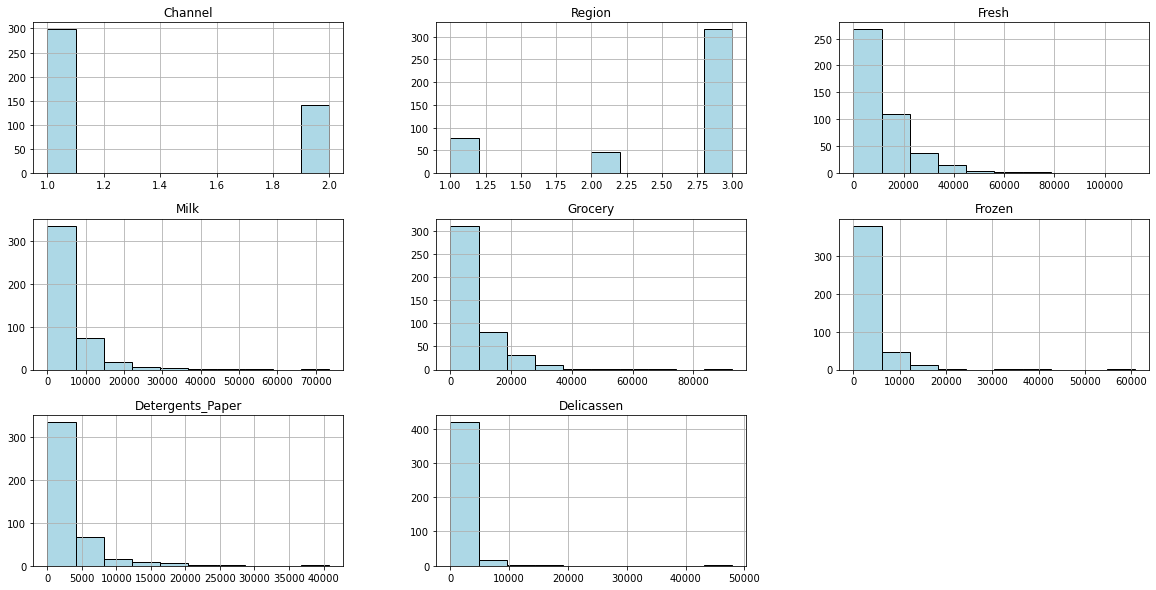

In [11]:
## plotting distribution graph
df.hist(figsize=(20,10),color='lightblue', edgecolor='black')
plt.show()

The data appears to be very skewed and "rich" in outliers. This can negatively affect analysis since KMeans is susceptible to influential outlying values. In such a situation, we deploy the Box-Cox method.

In [13]:
from scipy.stats import boxcox
data=df.copy()

lamb=[]
confidence=[]
for i in data.columns[2:]:
    data[i], coef, conf=boxcox(data[i]+0.0000001, alpha=0.05)   #We add a tiny constant as values need to be positive 
                                                                #for Box-Cox
    lamb.append(coef)
    confidence.append(conf)

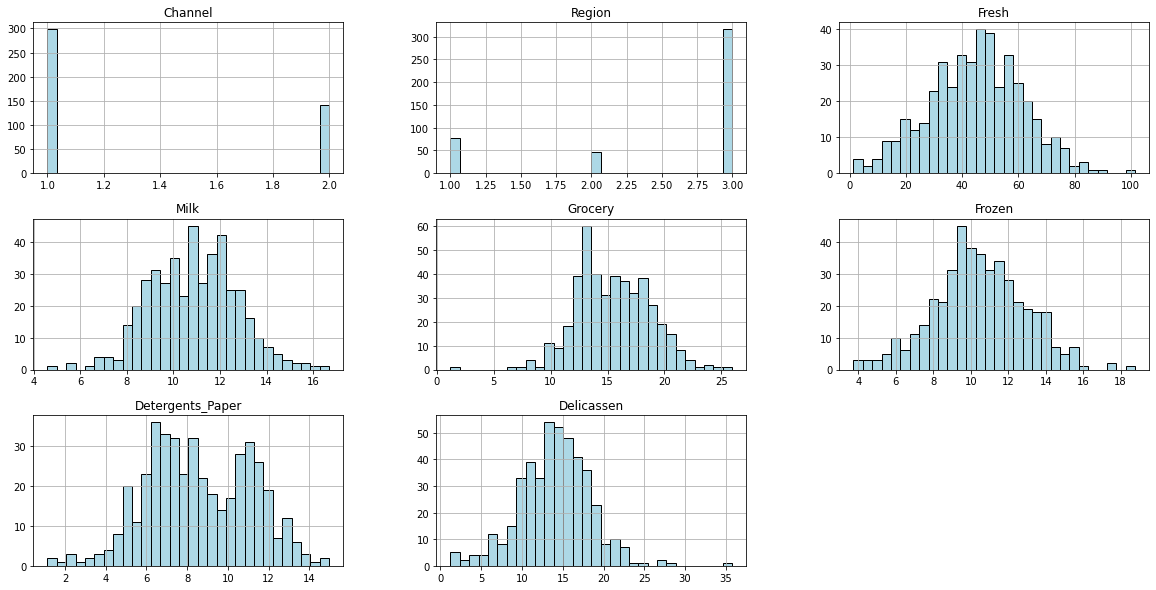

In [14]:
data.hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

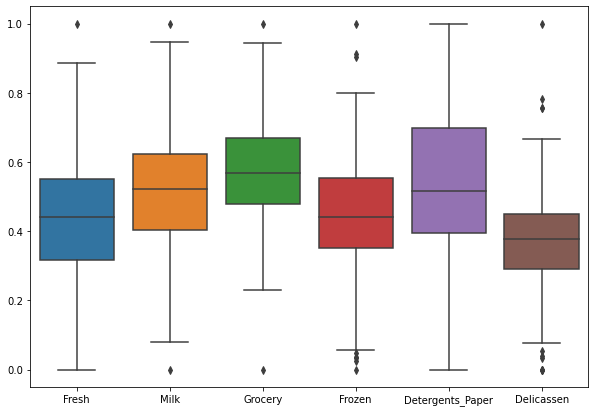

In [16]:
from sklearn.preprocessing import MinMaxScaler

norm=data.iloc[:,2:] #Numerical data

scaler=MinMaxScaler()
columns=data.columns[2:]
norm=scaler.fit_transform(data.iloc[:,2:]) #Only numeric variables
norm=pd.DataFrame(norm, columns=columns)

plt.figure(figsize=(10,7))
sns.boxplot(data=norm)
plt.show()

In [17]:
## to supress the outliers we take the take the interqutile range and cap the outliers to 75th and 25th percentile 
for i in norm.columns:
    iqr=np.percentile(norm[i], 75)-np.percentile(norm[i], 25)
    per75=np.percentile(norm[i], 75)
    per25=np.percentile(norm[i], 25)
    norm[i]=np.where(norm[i]>per75+1.5*iqr, per75+1.5*iqr,norm[i] )
    norm[i]=np.where(norm[i]<per25-1.5*iqr, per25-1.5*iqr,norm[i] )

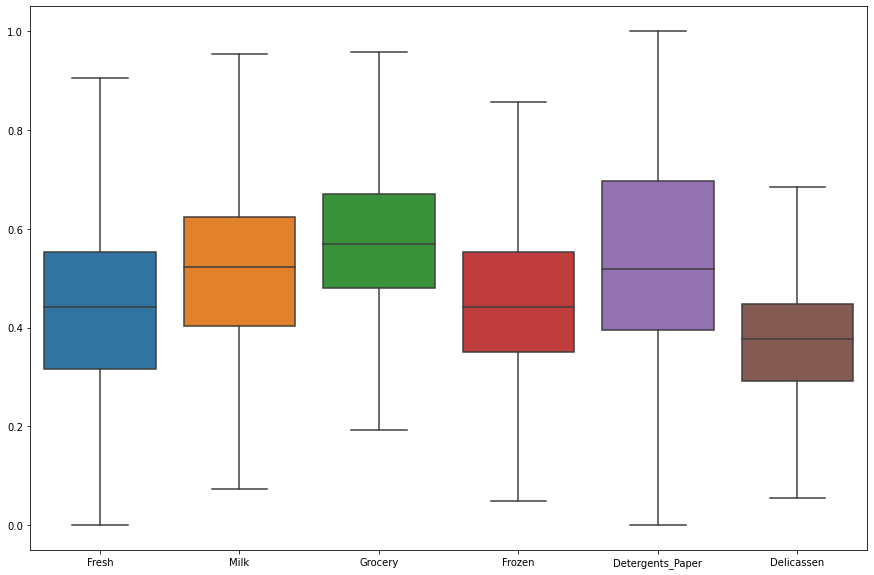

In [18]:
#Now we don´t have outliers

plt.figure(figsize=(15,10))
sns.boxplot(data=norm)
plt.show()

outliers are completely reduced

In [19]:
## one hot encoding for Region and Channel

data=pd.get_dummies(data=df, columns= ['Region','Channel'], drop_first=True)
data.iloc[:,:6]=norm

## Modelling and Analysis

In [20]:
## kmeans clustering
from sklearn.cluster import KMeans
wcss=[]
for i in range(2,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    print(kmeans.inertia_)
    

176.50614674803177
105.37999889895535
73.79056698212926
54.70564707764686
45.364025250606375
39.47485906719739
36.0608216318059
33.42243416504625
31.993858675172234


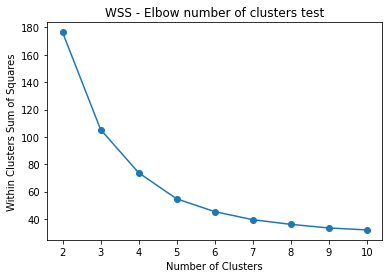

In [24]:
## elbow plot
plt.plot(range(2,len(wcss)+2) , wcss, 'o-')
plt.title('WSS - Elbow number of clusters test')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Clusters Sum of Squares')
plt.show()

In [25]:
##Sillhoutte score to validate the elbow graph
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
range_n_clusters = np.arange(2, 11)

for n_clusters in range_n_clusters:

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)

    silhouette_avg = silhouette_score(data, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.4399604732422569
For n_clusters = 3 The average silhouette_score is : 0.5154169716308427
For n_clusters = 4 The average silhouette_score is : 0.5643692783212912
For n_clusters = 5 The average silhouette_score is : 0.5933329517171968
For n_clusters = 6 The average silhouette_score is : 0.6122749843520386
For n_clusters = 7 The average silhouette_score is : 0.4298117890530042
For n_clusters = 8 The average silhouette_score is : 0.42653896039085387
For n_clusters = 9 The average silhouette_score is : 0.3390548360153147
For n_clusters = 10 The average silhouette_score is : 0.28751319627777017


In [37]:
kmeans=KMeans(init='k-means++' , n_clusters=6, random_state=0)
cluster_model=kmeans.fit(data)
df['clusters']=cluster_model.predict(data).astype('str')
data['clusters']=df['clusters']


In [38]:
from sklearn.decomposition import PCA

pca=PCA(n_components=len(data.columns)-1)

pca.fit(data.iloc[:,:-1])

pca.explained_variance_ratio_

array([0.39804722, 0.36827827, 0.08376414, 0.05943256, 0.0361975 ,
       0.02340303, 0.01591205, 0.01056671, 0.00439852])

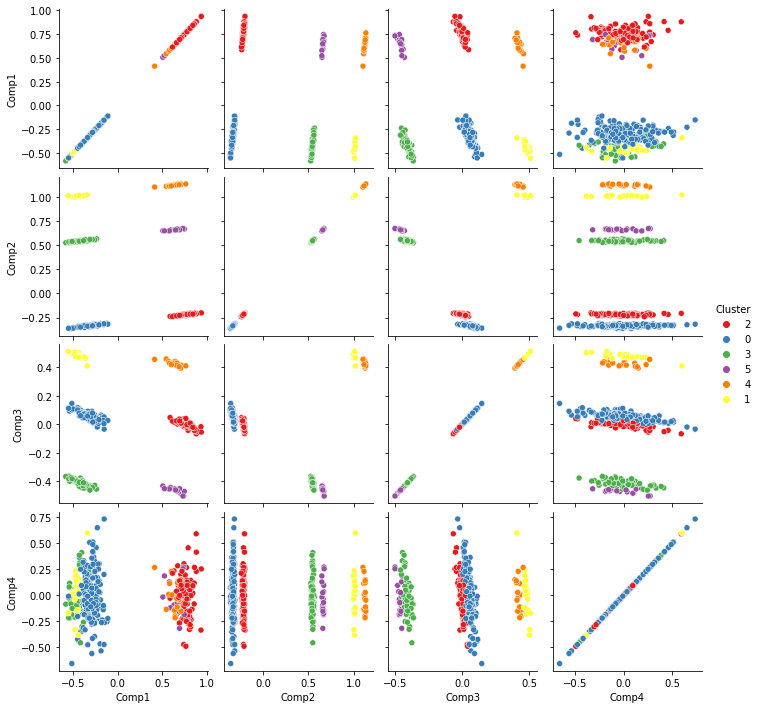

In [40]:
pca=PCA(n_components=4)
reduced=pca.fit_transform(data.iloc[:,:-1])

reduced=pd.DataFrame(np.column_stack([reduced, data.clusters]), columns=['Comp1','Comp2','Comp3','Comp4','Cluster'])

sns.pairplot(reduced, hue='Cluster', diag_kind=None, vars=reduced.columns[0:-1], palette='Set1')
plt.show()

In [42]:
## Agglomerative Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
hierarchy=AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward', compute_distances=True)

df['Hierarchical_clusters']=hierarchy.fit_predict(data)
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,clusters,Hierarchical_clusters
0,2,3,12669,9656,7561,214,2674,1338,2,2
1,2,3,7057,9810,9568,1762,3293,1776,2,2
2,2,3,6353,8808,7684,2405,3516,7844,2,2
3,1,3,13265,1196,4221,6404,507,1788,0,0
4,2,3,22615,5410,7198,3915,1777,5185,2,2
...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,0,0
436,1,3,39228,1431,764,4510,93,2346,0,0
437,2,3,14531,15488,30243,437,14841,1867,2,2
438,1,3,10290,1981,2232,1038,168,2125,0,0


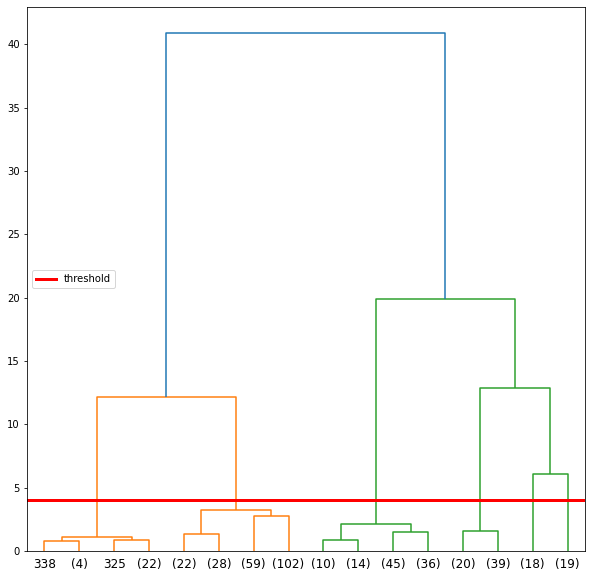

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(10,10))
dendrogram(linkage(data ,method='ward'), truncate_mode='level', p=3 )
plt.axhline(y=4, label='threshold', color='red', lw=3)
plt.title='Dendrogram'
plt.legend(loc=6)
plt.show()